In [2]:
from graph2gnn import Tiger2GNN
import logging, json, os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from time import perf_counter
from collections import defaultdict
from tqdm import trange
import requests as req
import warnings

# warnings.filterwarnings("ignore")

class Twitch2GNN(Tiger2GNN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def compute_vectors(self):
        vectors = []  # list of (id, vector, label)
        intermediate = []
        # For each vertex in the query's result set
        vert_types = [x for x in glob(f"{self.output_path}/*.json")]
        print(vert_types)

        # for every v_type
        for path in vert_types:
            columns = ["id", "label"]
            vertex_list = json.load(open(path))
            vert_type = path.split(".json")[0].split("/")[1]

            # for every vertex
            for vert in tqdm(vertex_list, desc=vert_type):
                features = np.ones((1,))  # feature placeholder. Put your real features here if you have any. This graph has none
                intermediate = [vert["id"]]
                if vert_type == 'Users':
                    label = vert["attrs"]["label"]
                else:
                    label = -1
                intermediate.append(label)
                intermediate.extend(features)
                vectors.append(intermediate.copy())
                intermediate.clear()
            assert len(vectors) > 0
            feature_cols = [f"feat_{i}" for i in range(len(features))]
            feature_cols = columns + feature_cols
            pd.DataFrame(vectors, columns=feature_cols).to_csv(
                f"{self.output_path}/{vert_type}.csv", index=False
            )
            vectors.clear()


with open('tkn.txt') as fin:
	lines = fin.readlines()

tkn = lines[0] #restpp token
host = lines[1] 

tg = Twitch2GNN(
    host=f"http://{host}",
    graph_name="TwitchEgos",
    query="TwitchEgosData",
    token=tkn,
    log_level=logging.INFO
)
# tg.output_path = 'tgresponse_small'


In [3]:
tg.call_subgraph_query(params={'total_partitions':10})
tg.compute_vectors()

In [4]:
# take a peak at the label distribution
from matplotlib import pyplot as plt
import pandas as pd

stats = pd.read_csv('tgresponse/Users.csv')[['id','label']]
stats = stats.loc[stats.label != -1]
ax = stats.label.plot.hist(rot=45)#, color=['r','g'])
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
# assemble the graphs (using concurrent processing)
!python3 assemble_parallel.py $tg.output_path

In [6]:
# DATASET
import dgl, torch
from dgl.data import DGLDataset


class TwitchDataset(DGLDataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

    @property
    def num_classes(self):
        return self._num_classes

    def process(self):
        graphs = glob(f"{tg.output_path}/subgraph/*_vectors.csv")[:10_000]
        self.graphs = []
        self.labels = []
        self.graph_ids = []

        # For each graph ego...
        t = tqdm(graphs, desc="assemble graphs")
        err = 0
        for graph_path in t:
            graph_id = graph_path.split("/")[-1].split("_")[
                0
            ]  # get just the ID part of the file path

            # Get the edges
            if not os.path.exists(f"{tg.output_path}/subgraph/{graph_id}_edges.csv"):
                continue
            try:
                edges_of_subgraph = pd.read_csv(
                    f"{tg.output_path}/subgraph/{graph_id}_edges.csv"
                ).sort_values(by="src")
                dgl_id = {
                    k: v
                    for v, k in enumerate(
                        np.unique(edges_of_subgraph[["src", "tgt"]].to_numpy().flatten())
                    )
                }  # change from tg_vid to dgl 0-based idx
                edges_of_subgraph["dgl_src"] = [dgl_id[i] for i in edges_of_subgraph.src]
                edges_of_subgraph["dgl_tgt"] = [dgl_id[i] for i in edges_of_subgraph.tgt]
                src = edges_of_subgraph["dgl_src"].to_numpy()
                dst = edges_of_subgraph["dgl_tgt"].to_numpy()

                verts = pd.read_csv(graph_path)
                verts = verts.sort_values(by="id")
                label = verts.loc[verts.id == int(graph_id)].label.iloc[0]

                
                assert label is not None
                feature_cols = [x for x in verts.columns if "feat_" in x]
                vertex_vectors = torch.from_numpy(verts[feature_cols].to_numpy())
            except:
                print(graph_path)
                err+=1
                print(err)

            try:
                g = dgl.graph((src, dst), num_nodes=vertex_vectors.shape[0])
                g.ndata["h"] = vertex_vectors.float()
                g = dgl.add_reverse_edges(g)
                g = dgl.add_self_loop(g)
                self.graphs.append(g)
                self.labels.append(torch.scalar_tensor(label, dtype=torch.float32))
                self.graph_ids.append(graph_id)
            except Exception as e:
                err += 1
                t.desc = f"err: {err}"
                # continue
                print(graph_id)
                print(verts.shape)
                print(len(dgl_id.keys()))
                print(len(vertex_vectors))
                raise e

        # # Convert the label list to tensor for saving.
        self.labels = torch.tensor(self.labels)


assemble graphs: 100%|██████████| 10000/10000 [01:03<00:00, 157.53it/s]


idx: 1
graph_id: 186308
label: 0.0

num nodes: 49, 49


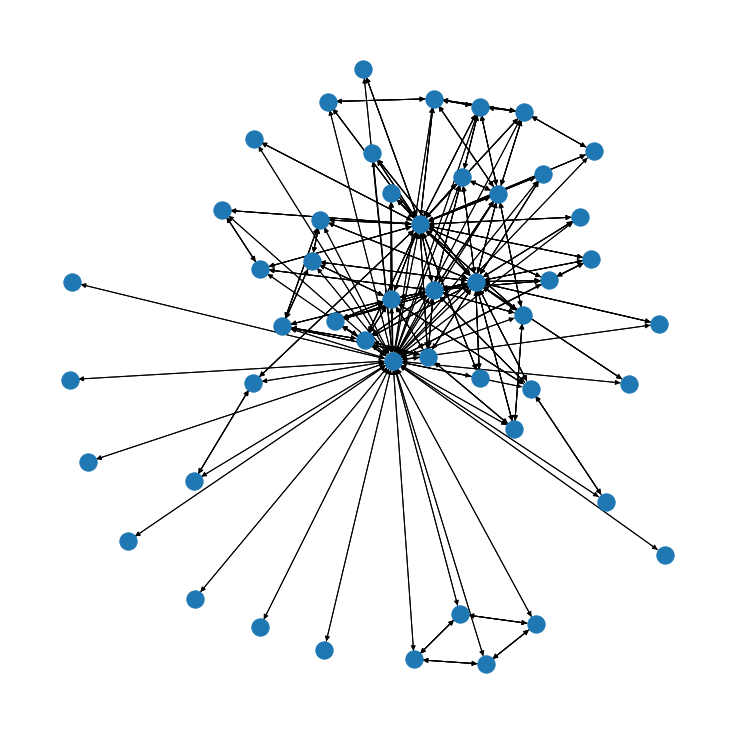

In [7]:
from matplotlib import pyplot as plt
import networkx as nx
try: dataset
except: dataset = TwitchDataset(name="Twitch")
assert len(dataset.graph_ids) > 0
# idx = np.random.randint(len(dataset.graph_ids))
idx = 1
print(f"idx: {idx}")
g, l = dataset[idx]
print(f'graph_id: {dataset.graph_ids[idx]}')
print(f'label: {l}')
print()
plt.figure(figsize=(10, 10))
G: nx.Graph = g.to_networkx()
print(f'num nodes: {g.num_nodes()}, {G.number_of_nodes()}')
self_loops = []
for u, v in G.edges():
    if u == v:
        self_loops.append((u, v))
        # G.remove_edge(u,v)
G.remove_edges_from(self_loops)
nx.draw(G)


In [8]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)
batch_size = 64

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=batch_size, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=batch_size, drop_last=False)

print(len(train_dataloader))
print(len(test_dataloader))
next(zip(train_dataloader,test_dataloader))

125
32


([Graph(num_nodes=1971, num_edges=24469,
        ndata_schemes={'h': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={}),
  tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
          0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
          0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
          0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])],
 [Graph(num_nodes=1993, num_edges=21107,
        ndata_schemes={'h': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={}),
  tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
          0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 1., 1., 0.])])

In [9]:
import dgl.nn.pytorch as dglnn
# import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class twitch_model(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(twitch_model, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, n_classes)

    def forward(self, g:dgl.DGLGraph, h):
        x = self.conv1(g, h)
        # x = F.leaky_relu(x)

        g.ndata['h'] = x
        x = dgl.sum_nodes(g,'h')
        return self.out(x)

In [10]:
# # x = torch.tensor([20], dtype=torch.float32)
# model = twitch_model(1, 8, 2)

# t = iter(train_dataloader)
# t.desc = f"Epoch {0}"
# for batched_graph, labels in t:
#     print(labels.shape)
#     print(batched_graph, labels.shape)
#     h = batched_graph.ndata["h"]
#     logits = model(batched_graph, h)
#     break
# print(logits.shape)
# logits.argmax(1)


  0%|          | 0/125 [00:00<?, ?batch/s]/var/folders/rn/tvgft9fx4m154s0lhnmgx5km0000gq/T/ipykernel_4428/3419464129.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(logits.argmax(1), dtype=torch.float, requires_grad=True)
Epoch 0: 100%|██████████| 125/125 [00:00<00:00, 207.36batch/s, acc=0.547]
/var/folders/rn/tvgft9fx4m154s0lhnmgx5km0000gq/T/ipykernel_4428/3419464129.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_test = torch.tensor(
Epoch 4: 100%|██████████| 125/125 [00:00<00:00, 326.64batch/s, acc=0.578]


train_acc    float64
test_acc     float64
loss         float64
test_loss    float64
dtype: object


<AxesSubplot:>

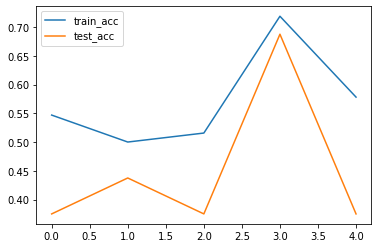

In [11]:
import numpy as np


def train(tr_dataloader, test_dataloader, model):
    learning_rate = 1e-2

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5
    )

    history = []
    for e in range(5):
        t = tqdm(tr_dataloader, unit="batch")
        t.desc = f"Epoch {e}"
        for batched_graph, labels in t:
            # Forward
            h = batched_graph.ndata["h"]
            logits = model(batched_graph, h)
            pred = torch.tensor(logits.argmax(1), dtype=torch.float, requires_grad=True)
            # pred = logits.argmax(1).to(torch.float)
            loss = F.binary_cross_entropy_with_logits(pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc = (pred == labels).float().mean()
            t.set_postfix(acc=train_acc.item())

        for batched_graph, labels in test_dataloader:
            h = batched_graph.ndata["h"]
            logits_test = model(batched_graph, h)
            pred_test = torch.tensor(
                logits_test.argmax(1), dtype=torch.float, requires_grad=True
            )
            # pred_test = logits_test.argmax(1).to(torch.float)
            test_loss = F.binary_cross_entropy_with_logits(pred_test, labels)
            test_acc = (pred_test == labels).float().mean()

        history.append(
            [train_acc.item(), test_acc.item(), loss.item(), test_loss.item()]
        )

    return history


model = twitch_model(1, 8, 2)
history = train(train_dataloader, test_dataloader, model)
import pandas as pd
df = pd.DataFrame(history, columns=['train_acc', 'test_acc', 'loss', 'test_loss'])
print(df.dtypes)

df[['train_acc','test_acc']].plot()


<AxesSubplot:>

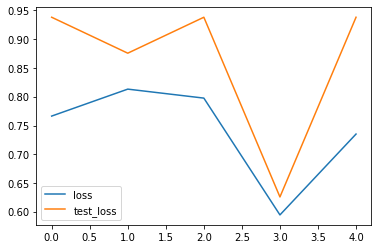

In [13]:
df[['loss','test_loss']].plot()